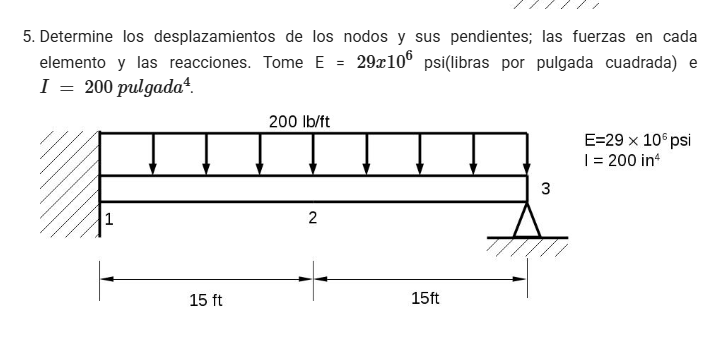

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
def vectorb0(cantDeElementos,w,L):
    #   Definicion del vector de fuerzas y momentos

    F = np.zeros([cantDeElementos + 1])     # Se tiene una fuerza por cada nodo del sistema
    M = np.zeros([cantDeElementos + 1])     # Se tiene un momento por cada nodo del sistema

    auxF = 0
    auxM = 0

    for n in range (cantDeElementos):

        #   Estas serian las fuerzas para cada nodo 

        aux1 = (- w * L) / 2 
        aux2 = (- w * L) / 2

        aux3 = -(w*L**2) / 12
        aux4 = - aux3

        #   Se debe sumar las fuerzas actuantes en cada nodo

        F[n] = aux1 + auxF
        F[n+1] = aux2

        auxF = aux2

        M[n] = aux3 + auxM
        M[n+1] = aux4

        auxM = aux4

    #.....................................................................................................

    #   .................. DEFINICION DE LAS CONDICIONES DE CONTORNO .................................................

    #   De acuerdo a como esta definido el metodo empleado, para cada nodo ... es posible definir 4 datos distintos

    #   .... FUERZA - DESPLAZAMIENTO - MOMENTO - ANGULO ...............................................................

    #   Cada nodo tendra 2 filas en mi vector b.

    #           b = np.array([[  a0 ,  b0 ],       
    #                         [  c0 ,  d0 ],
    #                              ...       
    #                         [  ai ,  bi ],
    #                         [  ci ,  di ],      
    #                              ...      
    #                         [  an ,  bn ],  
    #                         [  cn ,  dn ]])

    #   Si ai == 0 entonces:
    #       Se conoce el valor de "FUERZA" -> bi == valor
    #   Si ai == 1 entonces:
    #       Se conoce el valor de "DESPLZAMIENTO" -> bi == valor

    #   Si ci == 0 entonces: 
    #       Se conoce el valor de "MOMENTO" -> di == valor
    #   Si ci == 1 entonces:
    #       Se conoce el valor de "ANGULO" -> di == valor

    #   ................................................................................................................

    #   En este caso se conoce tanto la fuerza como el momento en cada nodo. Por lo que todos los valores en la primer columna son cero.
    #   Se debe intercalar los valores de F y M paa cada nodo en la matiz b

    b = np.zeros([(cantDeElementos + 1)*2,2], dtype = int)

    for i in range(cantDeElementos + 1):
        b[2*i, 1] = F[i]
        b[2*i+1, 1] = M[i]

    return b , F, M

In [3]:
def MatrizMNMC(cantDeElementos,L):

        #............... DEFINO MI MATRIZ DE NODOS ..........................................

    MN = np.zeros(([cantDeElementos + 1 ,2]),dtype=float)

    for e in range(cantDeElementos + 1):
        aux = e * L / cantDeElementos
        MN[e,0] = aux

    #............... DEFINO MI MATRIZ DE ELEMENTOS .......................................

    MC = np.zeros(([cantDeElementos,2]),dtype=int)

    for e in range(cantDeElementos):
        MC[e, 0] = e
        MC[e, 1] = e + 1 

    return MN , MC

In [4]:
def MatrizDeRigidez(MC, MN, E, I, glxn):

	n,m = MC.shape		# n es la cantidad de elementos que va a tener mi sistema
	r,l = MN.shape

	KG = np.zeros((glxn*r,glxn*r))

	for e in range(n):  # Recorro los elementos del sistema

		#	Calculo la constate k que acompaña a cada matriz para cada elemento 
		
		L_e = MN[e+1, 0] - MN[e, 0]     #   Lo pongo asi para considerar que cada elemento pueda tener una longitud distinta
		
		k_e = ( E * I ) / (L_e)**3      #   Esta es la definicion de la constante presentada en TEORICA 6 Pag.21

		K = k_e * np.array([[   12      ,   6*L_e       ,   -12     ,   6*L_e       ],
					        [   6*L_e   ,   4*L_e*L_e   ,   - 6*L_e ,   2*L_e*L_e   ],
							[   -12     ,   -6*L_e      ,   12      ,   -6*L_e      ],
							[   6*L_e   ,   2*L_e*L_e   ,   -6*L_e  ,   4*L_e*L_e   ]])     #   Definicion de la matriz K para cada elemento
		
		#......................................................................................
		 	
		Ni = MC[e,0]
		Nj = MC[e,1]

		indices = np.array([ Ni * glxn , (Ni + 1) * glxn -1 , Nj * glxn , (Nj + 1) * glxn - 1])
		
		#	Esta funcion es para crear una malla de indices.

		KG[np.ix_(indices,indices)] += K

		#.........................................................................................
		
	return KG

In [5]:
def ResolverSistemaMixto (A,b):

    #   Se define el vecctor de las esferzos (Fuerzas o Momentos) y los desplazamientos (Lineales o en angulo)

    n, m = np.shape(b)

    F = np.zeros([n,1])
    U = np.zeros([n,1])

    aux = b[:, 0] == 0  # Donde se conoce el valor del esfuerzo
    aux2 = b[:, 0] == 1  # Donde se conoce el valor del desplazamiento

    I = np.arange(n) # Se define un vector de indices


    f_indices = I[aux]   # Índices conocidos de esfuerzo
    u_indices = I[aux2]  # Índices conocidos de dezplazamiento

    #   Esto asigna los valores que ya conozco a los vectores de Esfuerzo y Desplazamiento que quiero de mi problema

    F[aux] = b[aux,1].reshape(-1, 1) 
    U[aux2] = b[aux2,1].reshape(-1, 1)

    #   Construyo la matriz reducida

    A_red_f = A[np.ix_(f_indices,f_indices)]

    #A_red_u = A[np.ix_(u_indices,u_indices)]

    f_aux = F[f_indices]
    #u_aux = U[u_indices]

    #   Resuelvo el sistema de ecuaciones reducido
    
    u_sol = np.linalg.inv(A_red_f) @ (f_aux - A[np.ix_(f_indices,u_indices)] @ U[u_indices])

    #print(u_sol)

    #   Asigno los valores calculados a mi vector de Desplazamientos con CC

    U[f_indices] = u_sol

    F = np.dot(A,U)     # Se multiplican las matries para encontrar el vector de Esfuerzos ... 



    return U, F

In [6]:
def graficarDeformacion(cantelementos,MN,U):
    # Definición de la función v(x)
    v = lambda x, L, d1, d2, r1, r2: ((2 / L**3) * (d1 - d2) + (1 / L**2) * (r1 + r2)) * x**3 + ((-3 / L**2) * (d1 - d2) - (1 / L) * (2 * r1 + r2)) * x**2 + r1 * x + d1

    for e in range(cantelementos):

        L = MN[e+1, 0] - MN[e, 0]  # Longitud del elemento
        X = np.linspace(0, L, 50)  # Coordenadas locales dentro del elemento

        i = e * 2
        d1 = U[i]
        r1 = U[i+1]
        d2 = U[i+2]
        r2 = U[i+3]

        Y = v(X, L, d1, d2, r1, r2)  #  Se evalua el desplazamiento

        Xplot = np.linspace(MN[e, 0], MN[e+1, 0], 50)  # Coordenadas globales

        plt.plot(Xplot, Y, label=f'Elemento {e}')

    plt.title('Curvas de V(X)')
    plt.xlabel('x [ft]')
    plt.ylabel('v(x) [ft]')
    plt.grid(True)
    plt.legend() 
    plt.show()


In [7]:
def graficarDeformacion1(cantelementos, MN, U, etiqueta=''):
    v = lambda x, L, d1, d2, r1, r2: ((2 / L**3) * (d1 - d2) + (1 / L**2) * (r1 + r2)) * x**3 + ((-3 / L**2) * (d1 - d2) - (1 / L) * (2 * r1 + r2)) * x**2 + r1 * x + d1

    X_total = []
    Y_total = []

    for e in range(cantelementos):
        
        L = MN[e+1, 0] - MN[e, 0]
        X = np.linspace(0, L, 50)

        i = e * 2
        d1 = U[i]
        r1 = U[i+1]
        d2 = U[i+2]
        r2 = U[i+3]

        Y = v(X, L, d1, d2, r1, r2)
        Xplot = np.linspace(MN[e, 0], MN[e+1, 0], 50)

        X_total.extend(Xplot)
        Y_total.extend(Y)

    plt.plot(X_total, Y_total, label=etiqueta)  # Solo un label por curva

In [8]:
#   De acuerdo a lo presentado en la teoria para cada nodo del sistema se tiene como grados de libertad, un desplazamiento transversal y una rotacion.

glxn = 2 

In [13]:
# Datos el problema

E = 29e6   #    [libras por pulgada cuadrada]
L = 30     #    [ft] 
w= 200     #    [Carga distribuida lb/ft   ]

I = 200     #   [pulgada4] Momento de inercia

cantDeElementos = 3

b1, F1,M1= vectorb0(cantDeElementos,w,L)

# print(np.round(b1,5))
# print(np.round(F1,5))
# print(np.round(M1,5))

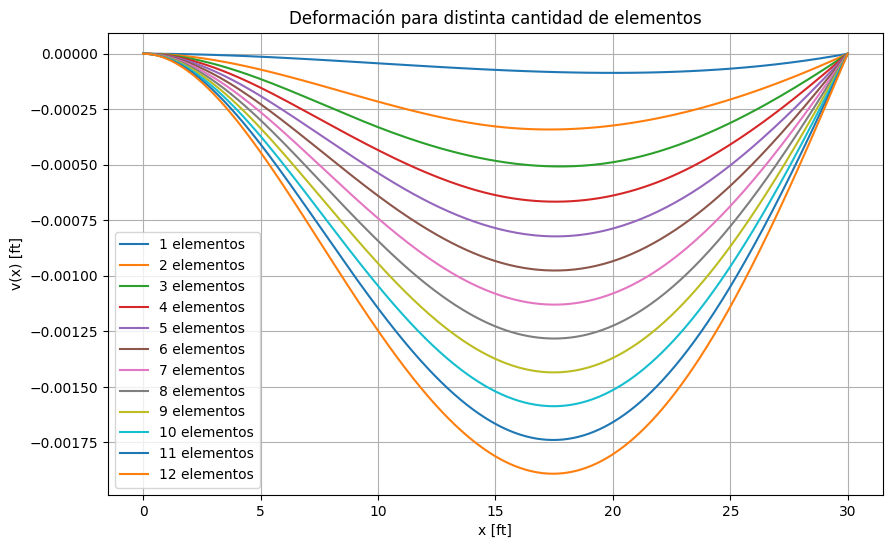

In [10]:
np.set_printoptions(suppress=True, precision=6)
plt.figure(figsize=(10, 6))

lis = np.array([1,2,3,4,5,6,7,8,9,10,11,12],dtype = int)

for elementos in lis:
    b, F,M= vectorb0(elementos,w,L)

    #   Agrego las condiciones de contorno que me dan los vinculos
    #   Por tratarse de un empotramiento se conoce el desplazamiento y la rotacion

    b[0, 0] = 1
    b[0, 1] = 0

    b[1, 0] = 1
    b[1, 1] = 0

    #   En el otro extemo se conoce el desplazmiento

    b[-2, 0] = 1
    b[-2, 1] = 0

    MN, MC = MatrizMNMC(elementos, L)
    KG = MatrizDeRigidez(MC, MN, E, I, glxn)

    U, F = ResolverSistemaMixto(KG, b)

    graficarDeformacion1(elementos, MN, U, etiqueta=f'{elementos} elementos')

plt.title("Deformación para distinta cantidad de elementos")
plt.xlabel("x [ft]")
plt.ylabel("v(x) [ft]")
plt.grid(True)
plt.legend()
plt.show()
